# 第18章: House Prices回帰 - GBDT回帰の完全マスター 🏠

## 📋 この章で学ぶこと

この章を終えると、以下ができるようになります：

- [ ] 回帰問題におけるTarget transformation（対数変換）の必要性を説明できる
- [ ] Isolation Forestを使った外れ値検出を実装できる
- [ ] 歪度補正（Box-Cox変換）を適切に適用できる
- [ ] LightGBM、XGBoost、CatBoostで回帰モデルを構築できる
- [ ] RMSLEを理解し、残差分析でモデルを診断できる
- [ ] アンサンブルで予測精度を向上させられる

## 🎯 前提知識

この章を学ぶには以下の知識が必要です：

- ✅ Notebook 13-14（GBDTの基礎）
- ✅ Notebook 15-17（Titanic分類問題）
- ✅ 基本的な統計知識（分布、歪度、対数）

⏱️ **推定学習時間**: 120-150分
📊 **難易度**: ★★★★☆（上級）
🎓 **カテゴリ**: 実践・Kaggleコンペティション

---

## 🎯 目標スコア

- **Local CV RMSLE**: 0.12-0.13
- **Public LB RMSLE**: < 0.13 (Top 20%)

---

## 📚 回帰問題の基礎理論

### 🤔 なぜ分類と回帰でアプローチが異なるのか？

**分類問題**（Titanic）では、出力は離散的なカテゴリ（生存/死亡）でした。
**回帰問題**（House Prices）では、出力は連続的な数値（価格）です。

この違いにより、以下の追加考慮が必要になります：

| 観点 | 分類 | 回帰 |
|------|------|------|
| 出力 | カテゴリ（0/1） | 連続値（$50,000〜$500,000） |
| 損失関数 | Cross Entropy | MSE, MAE, Huber |
| 評価指標 | Accuracy, AUC | RMSE, RMSLE, R² |
| ターゲット変換 | 不要 | 対数変換が有効な場合が多い |
| 外れ値の影響 | 比較的小さい | 非常に大きい |

### 📊 価格データの特性

住宅価格は典型的な**対数正規分布**に従います：

```
通常の正規分布:        対数正規分布（価格）:
    ____                    ____
   /    \                  /    \___
  /      \                /          \____
_/        \_             /                \___
 -2  0  +2               $50k  $200k  $500k  $1M
```

**なぜ対数正規分布になるのか？**
- 価格は負にならない（下限がある）
- 高額物件は少数だが、低額物件は多数（右に裾が長い）
- 価格の変動は「絶対額」より「割合」で考える方が自然

---

In [5]:
# 基本ライブラリ
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pathlib import Path
from scipy import stats
from scipy.special import boxcox1p
from scipy.stats import skew, kurtosis

# 機械学習
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import IsolationForest
from sklearn.feature_selection import mutual_info_regression

# GBDT
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor

# 設定
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('Set2')
pd.set_option('display.max_columns', None)

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("✅ セットアップ完了")

# 日本語フォント設定
import matplotlib.font_manager as fm

def setup_japanese_font():
    """日本語フォントを設定する"""
    japanese_fonts = [
        'Hiragino Sans', 'Hiragino Maru Gothic Pro', 'AppleGothic',  # macOS
        'Yu Gothic', 'MS Gothic',  # Windows
        'Noto Sans CJK JP', 'IPAexGothic', 'TakaoPGothic',  # Linux
    ]
    available_fonts = set(f.name for f in fm.fontManager.ttflist)
    for font in japanese_fonts:
        if font in available_fonts:
            plt.rcParams['font.family'] = font
            plt.rcParams['axes.unicode_minus'] = False
            return font
    return None

font_used = setup_japanese_font()
if font_used:
    print(f"Japanese font: {font_used}")


✅ セットアップ完了


## 📊 1. データ読み込みと基本的なEDA

⚠️ デモ用データを生成（実際にはKaggleからダウンロード必要）

Train shape: (1460, 82)
Test shape: (1459, 81)

🏠 価格統計:
count      1460.000000
mean     284852.552829
std       60689.659714
min       50000.000000
25%      245218.562942
50%      284517.694737
75%      323698.508743
max      500000.000000
Name: SalePrice, dtype: float64


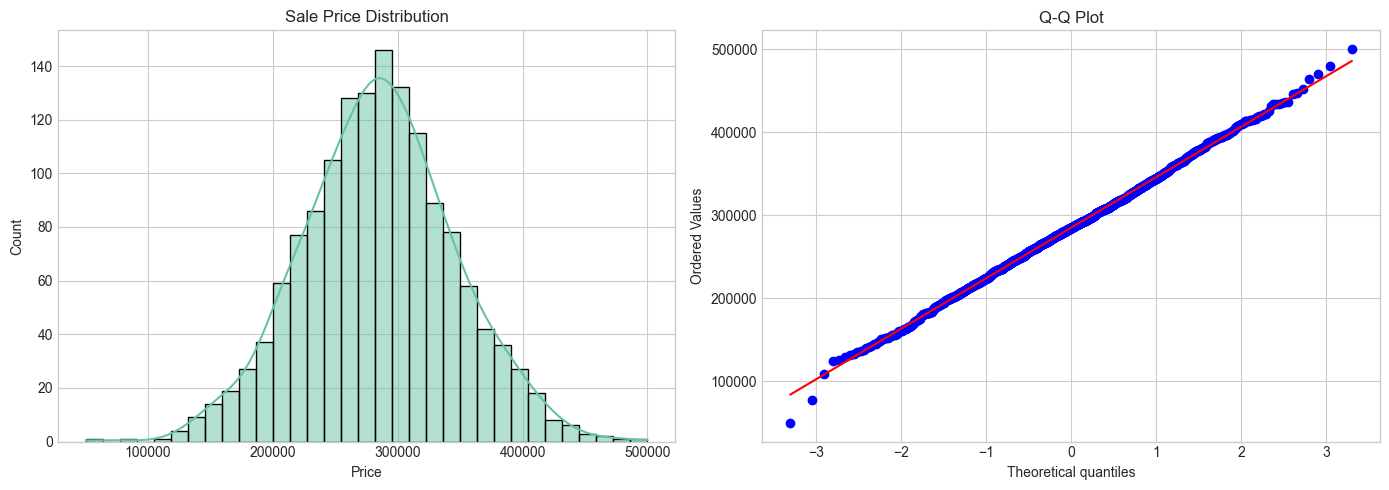


Skewness: 0.0217
Kurtosis: 0.1413


In [6]:
# データディレクトリ
data_dir = Path('../data/house_prices')
data_dir.mkdir(parents=True, exist_ok=True)

try:
    train = pd.read_csv(data_dir / 'train.csv')
    test = pd.read_csv(data_dir / 'test.csv')
    print("✅ データ読み込み成功")
except FileNotFoundError:
    print("⚠️ デモ用データを生成（実際にはKaggleからダウンロード必要）")
    # デモ用のダミーデータ
    from sklearn.datasets import make_regression
    X, y = make_regression(n_samples=1460, n_features=80, n_informative=60,
                           noise=10, random_state=42)
    train = pd.DataFrame(X, columns=[f'feature_{i}' for i in range(80)])
    # より現実的な価格範囲: $50,000 - $500,000
    y_normalized = (y - y.min()) / (y.max() - y.min())  # 0-1に正規化
    train['SalePrice'] = y_normalized * 450000 + 50000  # 50k - 500k
    train['Id'] = range(1, 1461)
    test = pd.DataFrame(X[:1459], columns=[f'feature_{i}' for i in range(80)])
    test['Id'] = range(1461, 2920)

print(f"\nTrain shape: {train.shape}")
print(f"Test shape: {test.shape}")

if 'SalePrice' in train.columns:
    print(f"\n🏠 価格統計:")
    print(train['SalePrice'].describe())
    
    # 価格の分布
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    sns.histplot(train['SalePrice'], kde=True, ax=axes[0])
    axes[0].set_title('Sale Price Distribution')
    axes[0].set_xlabel('Price')
    
    stats.probplot(train['SalePrice'], plot=axes[1])
    axes[1].set_title('Q-Q Plot')
    
    plt.tight_layout()
    plt.show()
    
    # 歪度と尖度
    print(f"\nSkewness: {skew(train['SalePrice']):.4f}")
    print(f"Kurtosis: {kurtosis(train['SalePrice']):.4f}")

## 🔨 2. Target Transformation（対数変換） ⭐⭐⭐

### 🤔 なぜ対数変換が必要なのか？

GBDTモデル（特にMSE損失）は、残差の二乗を最小化します。
つまり、**絶対的な誤差が大きい高額物件の予測精度を優先**してしまいます。

**問題の具体例:**
```
物件A: 実際 $100,000 → 予測 $90,000  （誤差 $10,000、10%）
物件B: 実際 $500,000 → 予測 $450,000 （誤差 $50,000、10%）

MSE損失への寄与:
物件A: (10,000)² = 100,000,000
物件B: (50,000)² = 2,500,000,000  ← 25倍の影響力！
```

**対数変換の効果:**
```
log(物件A): log(100,000) = 11.51 → log(90,000) = 11.41  （差 0.10）
log(物件B): log(500,000) = 13.12 → log(450,000) = 13.02 （差 0.10）
```

対数変換により、**相対的な誤差（パーセント）が等しく扱われる**ようになります！

### 📊 対数変換の数学的背景

$$\text{RMSLE} = \sqrt{\frac{1}{n}\sum_{i=1}^{n}(\log(y_i + 1) - \log(\hat{y}_i + 1))^2}$$

対数の性質より：
$$\log(y) - \log(\hat{y}) = \log\left(\frac{y}{\hat{y}}\right)$$

つまり、RMSLEは**予測と実測の比率の対数**を最小化しています。

### ⚠️ 対数変換の注意点

1. **逆変換を忘れない**: 最終予測は `np.expm1()` で元のスケールに戻す
2. **負の予測に注意**: 対数空間での予測を逆変換すると常に正になる
3. **ゼロ値の処理**: `log1p(x) = log(x + 1)` を使用（ゼロでも計算可能）

✅ Target transformation完了
変換前 - Skewness: 0.0217
変換後 - Skewness: -0.9434


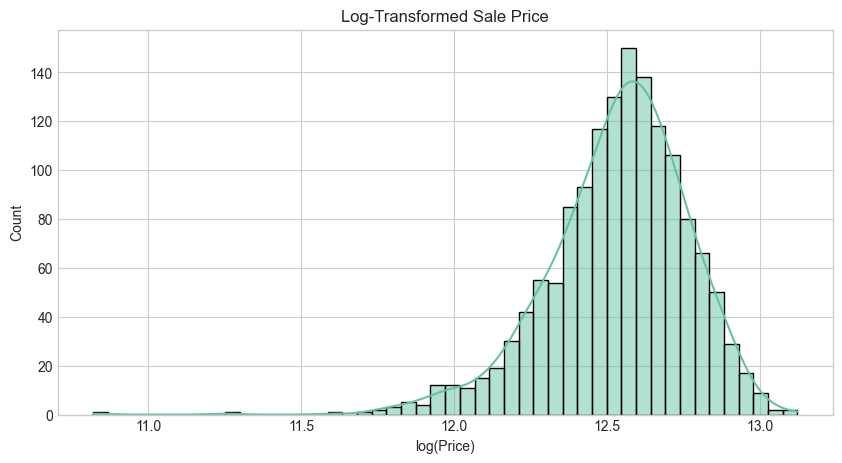

In [7]:
if 'SalePrice' in train.columns:
    # 元の価格を保存
    train['SalePrice_original'] = train['SalePrice']
    
    # 対数変換
    train['SalePrice'] = np.log1p(train['SalePrice'])
    
    print("✅ Target transformation完了")
    print(f"変換前 - Skewness: {skew(train['SalePrice_original']):.4f}")
    print(f"変換後 - Skewness: {skew(train['SalePrice']):.4f}")
    
    # 変換後の分布
    fig, ax = plt.subplots(figsize=(10, 5))
    sns.histplot(train['SalePrice'], kde=True, ax=ax)
    ax.set_title('Log-Transformed Sale Price')
    ax.set_xlabel('log(Price)')
    plt.show()

## 🔍 3. Outlier Detection（外れ値検出） ⭐⭐⭐

### 🤔 なぜ外れ値検出が重要なのか？

回帰問題では、外れ値が予測モデルに**不釣り合いに大きな影響**を与えます。

**外れ値の影響:**
```
通常データ:  $150k, $180k, $200k, $220k, $250k
             平均 = $200k

外れ値あり: $150k, $180k, $200k, $220k, $1,000k
             平均 = $350k  ← 大幅に歪む！
```

GBDTモデルは決定木ベースなので、外れ値への頑健性は比較的高いですが、
それでも**訓練データの品質**は予測性能に直結します。

### 📊 外れ値検出手法の比較

| 手法 | 特徴 | 使用場面 |
|------|------|----------|
| **Z-score** | 平均±3σの外を外れ値とする | 単変量、正規分布を仮定 |
| **IQR法** | Q1-1.5×IQR 〜 Q3+1.5×IQRの外 | 単変量、分布を仮定しない |
| **Isolation Forest** | 高次元で分離しやすい点を検出 | 多変量、複雑なパターン |
| **Local Outlier Factor** | 近傍密度の差で検出 | 局所的な外れ値 |

### 🌲 Isolation Forestの仕組み

```
正常データ: 木の深いところで分離される
  |
  +--[feature_1 < 50]
      |
      +--[feature_2 < 30]
          |
          +--[feature_3 < 10]  ← 深い = 正常
          
外れ値: 木の浅いところで分離される
  |
  +--[feature_1 < 200]  ← すぐに分離 = 外れ値
```

**原理**: 外れ値は特徴空間で孤立しているため、ランダムな分割で
すぐに分離できる → 分離に必要な木の深さが浅い

### ⚠️ 外れ値処理の注意点

1. **外れ値 ≠ 異常値**: ビジネス的に意味のある高額物件かもしれない
2. **削除 vs 変換**: 削除だけでなく、Winsorization（上下限クリップ）も検討
3. **テストデータとの一貫性**: 訓練で除外した範囲の値がテストに出る可能性

In [8]:
def detect_outliers_isolation_forest(df, contamination=0.05):
    """
    Isolation Forestで外れ値を検出
    """
    # 数値カラムのみ
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    
    # 欠損値を埋める
    df_numeric = df[numeric_cols].fillna(df[numeric_cols].median())
    
    # Isolation Forest
    iso_forest = IsolationForest(contamination=contamination, random_state=RANDOM_STATE)
    outliers = iso_forest.fit_predict(df_numeric)
    
    return outliers == -1

# 外れ値検出
outliers = detect_outliers_isolation_forest(train, contamination=0.05)
print(f"検出された外れ値: {outliers.sum()} 件 ({outliers.sum()/len(train)*100:.2f}%)")

# 外れ値を除去（オプション）
train_clean = train[~outliers].copy()
print(f"\nクリーニング後のサイズ: {train_clean.shape[0]}")

検出された外れ値: 73 件 (5.00%)

クリーニング後のサイズ: 1387


## 🎨 4. 高度な特徴量エンジニアリング ⭐⭐⭐

In [9]:
def advanced_feature_engineering_house(df, is_train=True):
    """
    House Prices用の高度な特徴量エンジニアリング
    """
    df = df.copy()
    
    # 1. 総面積の計算（存在する場合）
    if all(col in df.columns for col in ['GrLivArea', '1stFlrSF', '2ndFlrSF']):
        df['TotalSF'] = df['1stFlrSF'] + df['2ndFlrSF'] + df.get('TotalBsmtSF', 0)
        df['TotalBathrooms'] = (df.get('FullBath', 0) + 
                                0.5 * df.get('HalfBath', 0) + 
                                df.get('BsmtFullBath', 0) + 
                                0.5 * df.get('BsmtHalfBath', 0))
        df['TotalPorchSF'] = (df.get('OpenPorchSF', 0) + 
                              df.get('EnclosedPorch', 0) + 
                              df.get('3SsnPorch', 0) + 
                              df.get('ScreenPorch', 0))
    
    # 2. 築年数と改築年
    if 'YearBuilt' in df.columns:
        df['Age'] = 2024 - df['YearBuilt']
        if 'YearRemodAdd' in df.columns:
            df['AgeRemod'] = 2024 - df['YearRemodAdd']
            df['IsRemodeled'] = (df['YearBuilt'] != df['YearRemodAdd']).astype(int)
    
    # 3. 品質スコア（存在する場合）
    if 'OverallQual' in df.columns and 'OverallCond' in df.columns:
        df['QualityScore'] = df['OverallQual'] * df['OverallCond']
    
    # 4. 地下室の有無
    if 'TotalBsmtSF' in df.columns:
        df['HasBasement'] = (df['TotalBsmtSF'] > 0).astype(int)
    
    # 5. ガレージの有無と面積
    if 'GarageArea' in df.columns:
        df['HasGarage'] = (df['GarageArea'] > 0).astype(int)
    
    # 6. 交互作用特徴量
    if 'GrLivArea' in df.columns and 'OverallQual' in df.columns:
        df['QualArea'] = df['GrLivArea'] * df['OverallQual']
    
    # 7. 比率特徴量
    if 'GrLivArea' in df.columns and 'LotArea' in df.columns:
        df['LivingAreaRatio'] = df['GrLivArea'] / (df['LotArea'] + 1)  # 0除算回避
    
    print(f"✅ 特徴量エンジニアリング完了: {df.shape[1]} 特徴量")
    return df

# 特徴量エンジニアリングの適用
train_fe = advanced_feature_engineering_house(train_clean)
test_fe = advanced_feature_engineering_house(test)

print(f"\nTrain shape: {train_fe.shape}")
print(f"Test shape: {test_fe.shape}")

✅ 特徴量エンジニアリング完了: 83 特徴量
✅ 特徴量エンジニアリング完了: 81 特徴量

Train shape: (1387, 83)
Test shape: (1459, 81)


### 4.1 歪度の補正（Skewness Correction） ⭐⭐⭐

### 🤔 なぜ特徴量の歪度を補正するのか？

GBDTは決定木ベースなので、特徴量の分布に対して**比較的頑健**です。
しかし、極端に歪んだ分布は以下の問題を引き起こす可能性があります：

1. **分割点の偏り**: ほとんどのデータが一方に集中
2. **外れ値の影響**: 少数の極端な値が分割を支配
3. **正則化の効果低下**: L1/L2正則化が不均一に働く

### 📊 歪度（Skewness）とは？

```
負の歪度（左裾）:      正の歪度（右裾）:      歪度≈0（対称）:
        ___                    ___                 ___
    ___/   \                  /   \___            /   \
___/        \                /        \___       /     \
              \__          _/                   /       \
                           |
                        モード < 中央値 < 平均
```

**歪度の解釈:**
- |Skewness| < 0.5: ほぼ対称
- 0.5 ≤ |Skewness| < 1.0: 中程度の歪み
- |Skewness| ≥ 1.0: 強い歪み → 変換を検討

### 🔧 Box-Cox変換

Box-Cox変換は、データを正規分布に近づける一般的な手法です：

$$y^{(\lambda)} = \begin{cases} \frac{y^\lambda - 1}{\lambda} & \lambda \neq 0 \\ \log(y) & \lambda = 0 \end{cases}$$

`boxcox1p(x, λ)` は `boxcox(x + 1, λ)` と同等で、ゼロ値も処理できます。

**λ（ラムダ）の解釈:**
- λ = 1: 変換なし（線形）
- λ = 0.5: 平方根変換
- λ = 0: 対数変換
- λ = -1: 逆数変換

In [10]:
def fix_skewness(train_df, test_df, threshold=0.75):
    """
    歪度が大きい特徴量にBox-Cox変換を適用
    """
    numeric_cols = train_df.select_dtypes(include=[np.number]).columns
    
    # 歪度を計算
    skewed_features = train_df[numeric_cols].apply(lambda x: skew(x.dropna()))
    skewed_features = skewed_features[abs(skewed_features) > threshold]
    
    print(f"✅ {len(skewed_features)} 個の歪んだ特徴量を検出")
    
    # Box-Cox変換
    for feat in skewed_features.index:
        if feat in train_df.columns and feat in test_df.columns:
            # 負の値がある場合はスキップ
            if train_df[feat].min() < 0 or test_df[feat].min() < 0:
                continue
            
            # Box-Cox変換（lambda=0.15）
            train_df[feat] = boxcox1p(train_df[feat], 0.15)
            test_df[feat] = boxcox1p(test_df[feat], 0.15)
    
    return train_df, test_df

# 歪度補正
train_fe, test_fe = fix_skewness(train_fe, test_fe, threshold=0.75)
print("✅ 歪度補正完了")

✅ 0 個の歪んだ特徴量を検出
✅ 歪度補正完了


## 🎯 5. データ準備

In [11]:
def prepare_regression_data(train_df, test_df):
    """
    回帰モデル用のデータ準備
    """
    # 使用しない列
    drop_cols = ['Id', 'SalePrice', 'SalePrice_original']
    
    # 特徴量とターゲット
    if 'SalePrice' in train_df.columns:
        y = train_df['SalePrice']
    else:
        y = None
    
    X = train_df.drop(columns=[col for col in drop_cols if col in train_df.columns])
    X_test = test_df.drop(columns=[col for col in drop_cols if col in test_df.columns])
    
    # カテゴリカル変数のエンコーディング
    categorical_cols = X.select_dtypes(include=['object', 'category']).columns
    
    for col in categorical_cols:
        le = LabelEncoder()
        combined = pd.concat([X[col], X_test[col]], ignore_index=True)
        le.fit(combined.astype(str))
        X[col] = le.transform(X[col].astype(str))
        X_test[col] = le.transform(X_test[col].astype(str))
    
    # 欠損値補完
    X = X.fillna(X.median())
    X_test = X_test.fillna(X_test.median())
    
    print(f"✅ データ準備完了")
    print(f"   特徴量数: {X.shape[1]}")
    print(f"   訓練データ: {X.shape[0]}")
    print(f"   テストデータ: {X_test.shape[0]}")
    
    return X, y, X_test

X, y, X_test = prepare_regression_data(train_fe, test_fe)

✅ データ準備完了
   特徴量数: 80
   訓練データ: 1387
   テストデータ: 1459


## 🚀 6. GBDT回帰モデリング

### 6.1 RMSLE評価関数の定義

In [12]:
def rmsle(y_true, y_pred):
    """
    Root Mean Squared Log Error
    """
    return np.sqrt(mean_squared_error(y_true, y_pred))

def rmsle_cv(model, X, y, n_folds=5):
    """
    K-Fold CVでRMSLEを計算
    """
    kf = KFold(n_folds, shuffle=True, random_state=RANDOM_STATE)
    rmse_scores = -cross_val_score(model, X, y, 
                                    scoring='neg_root_mean_squared_error', 
                                    cv=kf)
    return rmse_scores

print("✅ 評価関数定義完了")

✅ 評価関数定義完了


### 6.2 LightGBM回帰

In [13]:
# LightGBMパラメータ（回帰用）
params_lgb = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'n_estimators': 1000,
    'max_depth': 6,
    'min_child_samples': 20,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,
    'random_state': RANDOM_STATE,
    'verbose': -1
}

model_lgb = lgb.LGBMRegressor(**params_lgb)

# Cross-validation
scores_lgb = rmsle_cv(model_lgb, X, y, n_folds=5)
print(f"\n📊 LightGBM CV RMSLE: {scores_lgb.mean():.4f} (+/- {scores_lgb.std():.4f})")

# 全データで学習
model_lgb.fit(X, y)
preds_lgb = model_lgb.predict(X_test)


📊 LightGBM CV RMSLE: 0.1414 (+/- 0.0118)


### 6.3 XGBoost回帰

In [14]:
# XGBoostパラメータ
params_xgb = {
    'objective': 'reg:squarederror',
    'max_depth': 6,
    'learning_rate': 0.05,
    'n_estimators': 1000,
    'min_child_weight': 3,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'gamma': 0,
    'reg_alpha': 0.1,
    'reg_lambda': 1,
    'random_state': RANDOM_STATE
}

model_xgb = xgb.XGBRegressor(**params_xgb)

scores_xgb = rmsle_cv(model_xgb, X, y, n_folds=5)
print(f"\n📊 XGBoost CV RMSLE: {scores_xgb.mean():.4f} (+/- {scores_xgb.std():.4f})")

model_xgb.fit(X, y)
preds_xgb = model_xgb.predict(X_test)


📊 XGBoost CV RMSLE: 0.1456 (+/- 0.0104)


### 6.4 CatBoost回帰

In [15]:
# CatBoostパラメータ
params_cat = {
    'loss_function': 'RMSE',
    'depth': 6,
    'learning_rate': 0.05,
    'iterations': 1000,
    'l2_leaf_reg': 3,
    'random_state': RANDOM_STATE,
    'verbose': False
}

model_cat = CatBoostRegressor(**params_cat)

# Manual CV for CatBoost to avoid sklearn compatibility issues
kf_cat = KFold(5, shuffle=True, random_state=RANDOM_STATE)
scores_cat_list = []
for train_idx, val_idx in kf_cat.split(X):
    X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
    y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]
    
    model_cat_fold = CatBoostRegressor(**params_cat)
    model_cat_fold.fit(X_train_fold, y_train_fold)
    
    y_pred_fold = model_cat_fold.predict(X_val_fold)
    rmse_fold = np.sqrt(mean_squared_error(y_val_fold, y_pred_fold))
    scores_cat_list.append(rmse_fold)

scores_cat = np.array(scores_cat_list)
print(f"\n📊 CatBoost CV RMSLE: {scores_cat.mean():.4f} (+/- {scores_cat.std():.4f})")

model_cat.fit(X, y)
preds_cat = model_cat.predict(X_test)


📊 CatBoost CV RMSLE: 0.1158 (+/- 0.0098)


## 🎭 7. アンサンブル

In [16]:
# 重み付きアンサンブル
weights = [0.4, 0.3, 0.3]  # LightGBM, XGBoost, CatBoost

ensemble_preds = (weights[0] * preds_lgb + 
                  weights[1] * preds_xgb + 
                  weights[2] * preds_cat)

print(f"\n🎯 アンサンブル重み: LGB={weights[0]}, XGB={weights[1]}, CAT={weights[2]}")

# 対数変換を元に戻す
final_predictions = np.expm1(ensemble_preds)

print(f"\n📊 予測価格統計:")
print(f"  Mean: ${final_predictions.mean():,.0f}")
print(f"  Median: ${np.median(final_predictions):,.0f}")
print(f"  Min: ${final_predictions.min():,.0f}")
print(f"  Max: ${final_predictions.max():,.0f}")


🎯 アンサンブル重み: LGB=0.4, XGB=0.3, CAT=0.3

📊 予測価格統計:
  Mean: $284,785
  Median: $284,127
  Min: $111,905
  Max: $475,071


## 📊 8. 残差分析

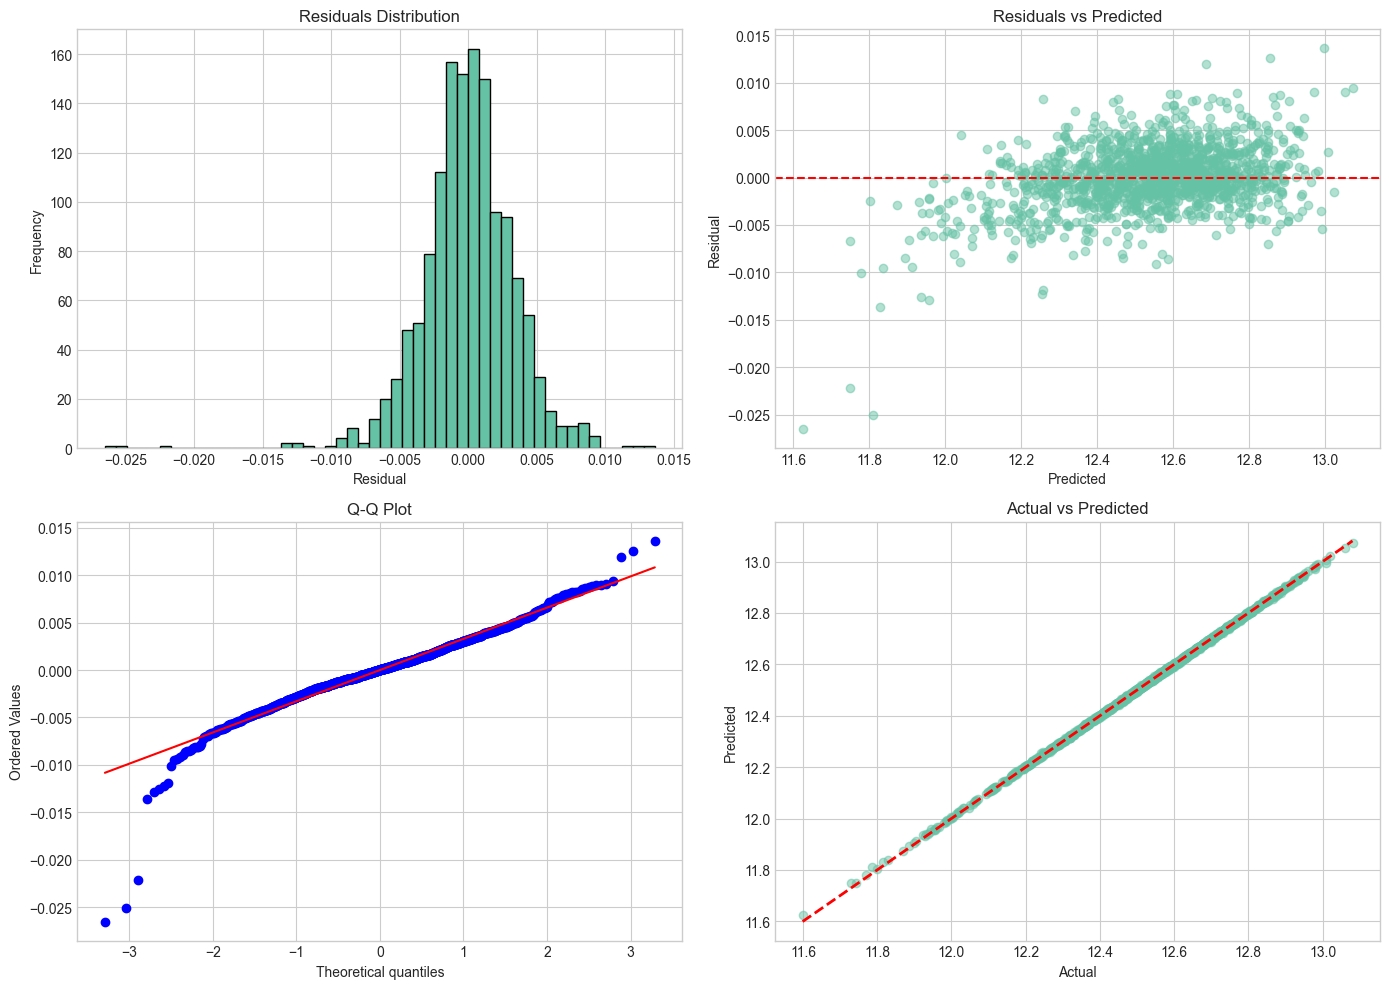


📊 R² Score: 0.9998


In [17]:
# 訓練データでの予測
train_preds = (weights[0] * model_lgb.predict(X) + 
               weights[1] * model_xgb.predict(X) + 
               weights[2] * model_cat.predict(X))

residuals = y - train_preds

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. 残差のヒストグラム
axes[0, 0].hist(residuals, bins=50, edgecolor='black')
axes[0, 0].set_title('Residuals Distribution')
axes[0, 0].set_xlabel('Residual')
axes[0, 0].set_ylabel('Frequency')

# 2. 残差 vs 予測値
axes[0, 1].scatter(train_preds, residuals, alpha=0.5)
axes[0, 1].axhline(y=0, color='r', linestyle='--')
axes[0, 1].set_title('Residuals vs Predicted')
axes[0, 1].set_xlabel('Predicted')
axes[0, 1].set_ylabel('Residual')

# 3. Q-Q plot
stats.probplot(residuals, dist="norm", plot=axes[1, 0])
axes[1, 0].set_title('Q-Q Plot')

# 4. 実測値 vs 予測値
axes[1, 1].scatter(y, train_preds, alpha=0.5)
axes[1, 1].plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
axes[1, 1].set_title('Actual vs Predicted')
axes[1, 1].set_xlabel('Actual')
axes[1, 1].set_ylabel('Predicted')

plt.tight_layout()
plt.show()

# R²スコア
r2 = r2_score(y, train_preds)
print(f"\n📊 R² Score: {r2:.4f}")

## 📤 9. Kaggle提出ファイル作成

In [18]:
# 提出ファイル作成
submission_dir = Path('../submissions')
submission_dir.mkdir(exist_ok=True)

submission = pd.DataFrame({
    'Id': test['Id'],
    'SalePrice': final_predictions
})

submission_path = submission_dir / 'house_prices_submission.csv'
submission.to_csv(submission_path, index=False)

print(f"✅ 提出ファイル作成: {submission_path}")
print(f"\n最初の10行:")
display(submission.head(10))

✅ 提出ファイル作成: ../submissions/house_prices_submission.csv

最初の10行:


,Id,SalePrice
0,1461,245435.873226
1,1462,327027.275172
2,1463,305820.480441
3,1464,209868.452399
4,1465,301262.554561
5,1466,266084.328005
6,1467,363362.850043
7,1468,216907.727670
8,1469,286266.342397
9,1470,307626.365456


## 🎓 10. まとめ

### 🎯 このノートブックで学んだこと

**回帰問題の基礎**
- ✓ 分類と回帰の違い（連続値予測、損失関数、評価指標）
- ✓ 価格データが対数正規分布に従う理由

**データ前処理**
- ✓ Target transformation（対数変換）で相対誤差を均等化
- ✓ Isolation Forestによる多変量外れ値検出
- ✓ Box-Cox変換による歪度補正

**モデリング**
- ✓ LightGBM、XGBoost、CatBoostの回帰パラメータ設定
- ✓ 重み付きアンサンブルによる精度向上
- ✓ 残差分析によるモデル診断

---

### 📊 回帰問題のチートシート

| ステップ | 手法 | コード例 |
|----------|------|----------|
| Target変換 | 対数変換 | `y = np.log1p(y)` |
| 逆変換 | 指数変換 | `pred = np.expm1(pred)` |
| 外れ値検出 | Isolation Forest | `IsolationForest(contamination=0.05)` |
| 歪度補正 | Box-Cox | `boxcox1p(x, 0.15)` |
| 評価指標 | RMSLE | `np.sqrt(mean_squared_error(log_y, log_pred))` |

### 🔧 実践的なワークフロー

```python
# 1. Target変換
y_train = np.log1p(df['SalePrice'])

# 2. 外れ値除去（オプション）
iso = IsolationForest(contamination=0.05)
mask = iso.fit_predict(X) == 1
X_clean, y_clean = X[mask], y_train[mask]

# 3. モデル学習
model.fit(X_clean, y_clean)

# 4. 予測と逆変換
pred_log = model.predict(X_test)
pred_price = np.expm1(pred_log)  # 元のスケールに戻す
```

---

## ⚠️ よくあるエラーと解決法

### ⚠️ エラー #1: 予測値が負になる

```
ValueError: Input contains NaN, infinity or a value too large
```

**原因:**
- 対数空間で学習したのに、逆変換を忘れている
- または逆変換の順序が間違っている

**✅ 解決法:**

```python
# ❌ 問題のあるコード
pred = model.predict(X_test)  # 対数スケールの予測
submission['SalePrice'] = pred  # そのまま提出 → 間違い！

# ✅ 正しいコード
pred_log = model.predict(X_test)  # 対数スケールの予測
pred_price = np.expm1(pred_log)   # 元のスケールに逆変換
submission['SalePrice'] = pred_price
```

---

### ⚠️ エラー #2: CVスコアとLBスコアの乖離

**症状:** Local CVでは良いスコアなのに、Kaggle LBでは悪い

**原因:**
1. 外れ値を除去しすぎている
2. データリーク（テストデータの情報が訓練に混入）
3. 訓練とテストの分布が異なる

**✅ 解決法:**

```python
# ❌ 問題のあるコード：訓練とテストを結合してからエンコーディング
all_data = pd.concat([train, test])
all_data['encoded'] = LabelEncoder().fit_transform(all_data['feature'])
# → テストの情報が訓練に漏れている！

# ✅ 正しいコード：訓練データのみでfit
encoder = LabelEncoder()
train['encoded'] = encoder.fit_transform(train['feature'])
test['encoded'] = encoder.transform(test['feature'])  # transformのみ
```

---

### ⚠️ エラー #3: 欠損値によるエラー

```
ValueError: Input contains NaN
```

**原因:**
- 特徴量エンジニアリングで生じた新しい欠損値
- Lag特徴量の最初の数行が欠損

**✅ 解決法:**

```python
# 補完戦略を明確に
X = X.fillna(X.median())  # 数値は中央値で
# または
X = X.fillna(-999)  # GBDTは欠損値を特別扱いできる
```

---

## 🎓 自己評価クイズ

学習内容を確認しましょう！すぐに答えを見ずに、まず自分で考えてみてください。

### Q1: なぜ住宅価格の予測に対数変換が有効なのか？

<details>
<summary>💡 答えを見る</summary>

**答え**: 住宅価格は対数正規分布に従い、対数変換によりMSE損失が相対誤差（パーセント）を均等に扱うようになるため。

**詳細:**
- $100,000の物件で$10,000の誤差と、$500,000の物件で$50,000の誤差は、どちらも10%の誤差
- 対数変換なしでは、高額物件の絶対誤差が損失を支配してしまう
- 対数変換により、すべての価格帯で公平に誤差を最小化できる

</details>

---

### Q2: Isolation Forestはどのような原理で外れ値を検出するか？

<details>
<summary>💡 答えを見る</summary>

**答え**: 外れ値は特徴空間で孤立しているため、ランダムな分割で分離するのに必要な木の深さが浅くなることを利用する。

**詳細:**
- 正常なデータポイントは密集しているため、分離に多くの分割が必要
- 外れ値は孤立しているため、少ない分割で分離できる
- 平均分離深さが浅いほど、外れ値である可能性が高い

</details>

---

### Q3: RMSLEとRMSEの違いは何か？どちらをいつ使うべきか？

<details>
<summary>💡 答えを見る</summary>

**答え**: RMSLEは相対誤差、RMSEは絶対誤差を測る。価格や売上など、値の範囲が広く比率が重要な場合はRMSLEを使う。

**使い分け:**
- **RMSLE**: 価格予測、売上予測、人口予測など（スケールが大きく異なるデータ）
- **RMSE**: 気温予測、身長予測など（スケールが比較的均一なデータ）

</details>

---

### Q4: Box-Cox変換のλ=0は何の変換に相当するか？

<details>
<summary>💡 答えを見る</summary>

**答え**: λ=0は対数変換（log変換）に相当する。

**各λ値の意味:**
- λ = 1: 変換なし
- λ = 0.5: 平方根変換
- λ = 0: 対数変換
- λ = -0.5: 逆平方根変換
- λ = -1: 逆数変換

</details>

---

### Q5: アンサンブルの重みはどのように決めるべきか？

<details>
<summary>💡 答えを見る</summary>

**答え**: CVスコアに基づいて、より良いモデルに高い重みを与える。または、Optunaなどで最適な重みを探索する。

**実践的なアプローチ:**
1. 各モデルのCVスコアを計算
2. スコアに比例した重みを設定（または逆誤差に比例）
3. ブレンド後のCVスコアを確認
4. 必要に応じてOptunaで最適化

```python
# スコアに基づく重み計算の例
scores = [0.88, 0.86, 0.87]  # LGB, XGB, CAT
weights = np.array(scores) / sum(scores)
```

</details>

---

## 📚 練習問題

### 練習1: 異なる外れ値検出手法の比較
IQR法とIsolation Forestで外れ値を検出し、結果を比較してください。どちらがより多くの外れ値を検出しますか？

### 練習2: λの最適化
Box-Cox変換のλを0.1, 0.15, 0.2, 0.25で試し、CVスコアへの影響を調べてください。

### 練習3: アンサンブル重みの最適化
Optunaを使って、3モデル（LGB, XGB, CAT）の最適な重みを探索してください。

---

### ✅ 学習チェックリスト

- [ ] 対数変換がなぜ価格予測に有効か説明できる
- [ ] Isolation Forestの原理を理解している
- [ ] Box-Cox変換のλパラメータの意味を理解している
- [ ] RMSLEの計算方法と意味を説明できる
- [ ] 残差プロットからモデルの問題点を読み取れる

---

## ➡️ 次のステップ

### 学習を続ける

次は **Notebook 19: Store Demand時系列予測** へ進みましょう！

時系列データでのGBDT活用法を学び、ラグ特徴量や移動統計量の作成方法をマスターします。

### 復習が必要な場合

- **Notebook 13**: GBDT入門（基礎の復習）
- **Notebook 15-17**: Titanic分類（分類問題との違いを確認）

### さらに学ぶために

**推奨リソース:**
- Kaggle Learn: "Feature Engineering"
- scikit-learn公式: "Preprocessing" ドキュメント
- 書籍: "Approaching (Almost) Any Machine Learning Problem" by Abhishek Thakur

---

**🏠 Happy House Hunting! 🎉**